# NLP (Natural Language Processing) with Python

### Imports

In [2]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 203.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.7 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 2.3 MB/s eta 0:00:0000:0100:01


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data

In [23]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')] #please update the path.
print(len(messages))

5574


In [24]:
for message_no, message in enumerate(messages[:3]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's




In [25]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', #please update the path.
                           names=["label", "message"])
messages.head()

label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

## Exploratory Data Analysis

In [26]:
messages.describe()

label                 message
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30

In [27]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [28]:
messages['length'] = messages['message'].apply(len)
messages.head()

label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61

### Data Visualization

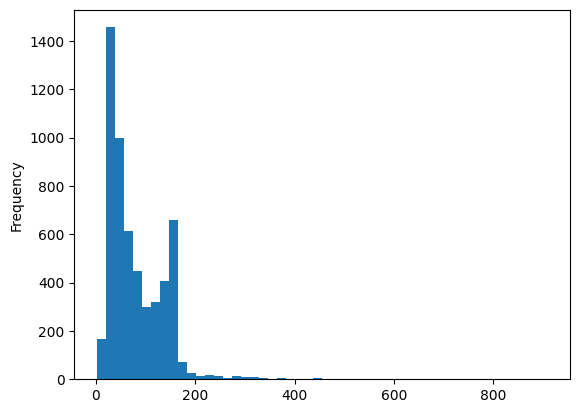

In [29]:
messages['length'].plot(bins=50, kind='hist');

In [30]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

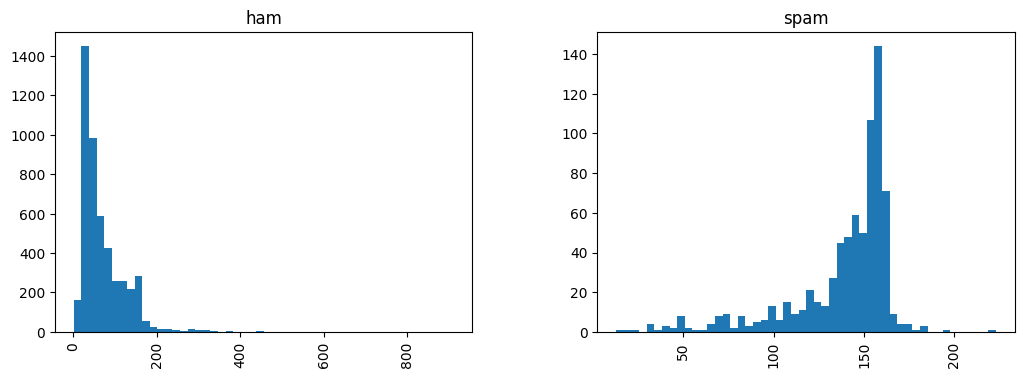

In [31]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4));

## Text Pre-processing

In [32]:
mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

In [33]:
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [34]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [35]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [36]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

In [37]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [38]:
messages.head()

label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61

In [39]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [40]:
# Show original dataframe
messages.head()

label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61

## Vectorization

In [41]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


In [42]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [43]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


In [44]:
print(bow_transformer.get_feature_names_out()[4073])
print(bow_transformer.get_feature_names_out()[9570])

UIN
schedule


In [45]:
messages_bow = bow_transformer.transform(messages['message'])

In [46]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [47]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [48]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


In [49]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


In [50]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


## Training a model

In [52]:
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

In [53]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


## Model Evaluation

In [54]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [55]:
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



## Train Test Split

In [56]:
msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


## Creating a Data Pipeline

In [57]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [58]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7feeff455240>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [59]:
predictions = pipeline.predict(msg_test)

In [60]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1010
        spam       0.71      1.00      0.83       105

    accuracy                           0.96      1115
   macro avg       0.86      0.98      0.91      1115
weighted avg       0.97      0.96      0.97      1115

